<a href="https://colab.research.google.com/github/heyraisin/image-captioning-challenge2/blob/master/Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
pwd

'/content/gdrive/My Drive/AI-Course/Challenge2'

In [ ]:
cd gdrive/MyDrive/AI-Course/Challenge2

Importing the libraries

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

filename = "Flickr8k/Flickr8k_text/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
# extract descriptions for images into key value format: id_image ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # remove filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

# load training dataset (6K)
filename = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
# Folder chứa dữ ảnh
images = 'Flickr8k/Flickr8k_Dataset/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')

In [ ]:
img[0]

'Flickr8k/Flickr8k_Dataset/2178064851_bb39652d28.jpg'

In [ ]:
# File stores id of images to train
train_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [ ]:
# File stores id of images to text
test_images_file = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [ ]:
# Add 'startseq', 'endseq' for the sequence
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
# Load ảnh, resize về khích thước mà Inception v3 yêu cầu.
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
# Create new model, remove last layer from inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Image embedding thành vector (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Gọi hàm encode với các ảnh trong traning set
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 614.1639416217804


In [ ]:
# Save image embedding
with open("Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:
# Encode test image
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 102.17091178894043


In [ ]:
# Save the bottleneck test features to disk
with open("Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Only take words appear up to 10 times
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
# Create model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 200)      330400      ['input_9[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  
model.save('./model/model.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


1000/1000 [==============================] - 160s 160ms/step - loss: 3.0547


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
images = 'Flickr8k/Flickr8k_Dataset/'

In [ ]:
with open("Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

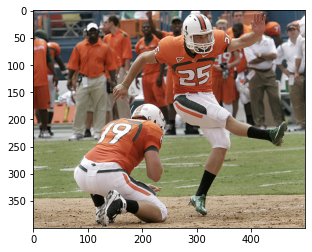

two men in red uniforms are playing on the field


In [ ]:
pic = list(encoding_test.keys())[20]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))